In [1]:
import matplotlib.pyplot as plt
import numpy as np
import parameters 
import device 
import network

/home/asude/.local/lib/python3.8/site-packages/samna
finished bindings


In [2]:
# open DYNAP-SE1 board to get Dynapse1Model
dynapse = device.DynapseDevice(sender_port=12321, receiver_port=12322)
model = dynapse.model


[0]:  Bus 3 Device 22 Dynapse1DevKit serial_number 00000027
[1]:  Bus 1 Device 121 Dynapse1DevKit serial_number 00000032
[2]:  Bus 1 Device 118 Dynapse1DevKit serial_number 00000000
[3]:  Bus 1 Device 120 Dynapse1DevKit serial_number 00000011
[4]:  Bus 1 Device 84 Dynapse1DevKit serial_number 00000007
[5]:  Bus 1 Device 34 Dynapse1DevKit serial_number 00000020
[6]:  Bus 1 Device 87 Dynapse1DevKit serial_number 00000033
Sender port: tcp://0.0.0.0:12321
Receiver port: tcp://0.0.0.0:12322
Opened device name: my_dynapse1
SamnaNode ID: 1
PythonNode ID: 2


In [29]:
chip = 0
core = 0
num_neurons = 4
nids = np.arange(1,num_neurons+1)

# init a network generator
net = network.DynapseNetworkGenerator()

# only use 1 spikegen No.15, [0,1024)
spikegen_id = 5
# 400 spikes in 2 second 
# duration of spikegen
duration = 1
rate = 800
# rates = np.repeat(rate, 8)
spike_times = np.linspace(0, duration, rate)
# spikegen id list corresponding to spike_times
indices = [spikegen_id]*len(spike_times)

# the chip where the post neurons are
post_chip = 0
target_chips = [post_chip]*len(indices)
isi_base = 900
repeat_mode=False

# get spikegen 
spikegen = net.get_spikegen(chip, core, spikegen_id)
fpga_gen = dynapse.get_fpga_spikegen(chip, core, spikegen_id, spike_times, repeat_mode)

# get and monitor neurons 
neurons = net.get_neurons(chip, core, nids)
dynapse.monitor_neuron_network(neurons)

# add connections
net.add_connections_one_to_all(spikegen, neurons, network.SYNAPSE_AMPA, 16)

# apply monitor configuration
model.apply_configuration(net.get_config())

Checking if the given network is valid to be deployed on DYNAP-SE1 chips...
Validation complete: the network is good to go!
Converted the validated network to a Dynapse1 configuration!


In [30]:
# set params
parameters.set_all_default_params(model)
# parameters.set_param(model, parameters.GABA_B_WEIGHT, (4,255), chip, core)
parameters.set_param(model, parameters.NEURON_DC_INPUT, (0,0), chip, core)
# parameters.set_param(model, parameters.NEURON_DC_INPUT, (0,0), chip, core)
# parameters.set_param(model, parameters.ADAPTATION_GAIN, (7,80), chip, core)
# parameters.set_param(model, parameters.ADAPTATION_TIME_CONSTANT, (1,80), chip, core)
# parameters.set_param(model, parameters.ADAPTATION_WEIGHT, (7,80), chip, core)
# parameters.set_param(model, parameters.ADAPTATION_SOMETHING, (3,80), chip, core)
parameters.set_param(model, parameters.AMPA_WEIGHT, (7,100), chip, core)
# leakage of AMPA
#  parameters.set_param(model, parameters.AMPA_TIME_CONSTANT, (2,80), chip, core)

941176512.0

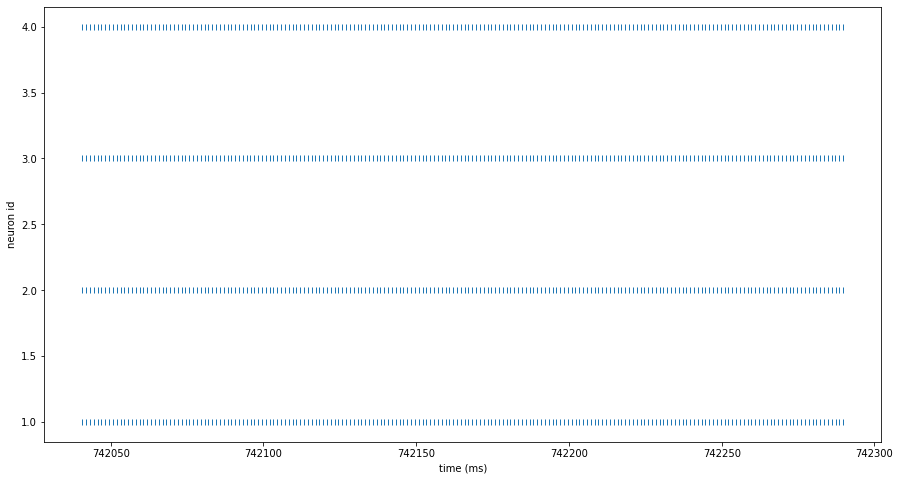

In [31]:
# duration of simulation
duration = 0.25
# start monitor
dynapse.start_graph()
# start the stimulus
fpga_gen.start()
# run experiment
dynapse.run_simulation(1)
spikes = dynapse.run_simulation(duration)
# stop the stimulus
fpga_gen.stop()
# stop graph
dynapse.stop_graph()

plt.figure(figsize=[15,8])
plt.plot([spike.timestamp/1000 for spike in spikes], [spike.id for spike in spikes],'|')
plt.xlabel('time (ms)')
plt.ylabel('neuron id')

plt.show()
